# Quantum Circuit Learning
**Quantum Circuit Learning** (QCL) is an algorithm for applying quantum computers to machine learning [1].
Just like the VQE (Variational Quantum Eigensolver) we have learned in the previous section, it is a **quantum-classical hybrid algorithm**, designed to operate on **NISQ** (Noisy Intermediate-Scale Quantum Computer), a medium-scale quantum computer without error correction function.

Experiments using actual NISQ devices have already been performed, and in March 2019, a paper on actual implementation of QCL by an IBM experiment team [2] was published in Nature and became a hot topic.

In the following, the outline of the algorithm and the specific learning procedure are introduced, then an implementation example using the quantum simulator Qulacs is presented.

This notebook is tranlated from https://dojo.qulacs.org/ja/latest/notebooks/5.1_variational_quantum_eigensolver.html

## Overview of QCL
In recent years, deep learning has been spotlighted in the field of machine learning.
In deep learning, by approximating a complex function using a deep neural network, the relationship between input and output can be learned and predictions can be performed on new data. QCL is a machine learning method that replaces this neural network with a **quantum circuit**, and hence a quantum computer. 

By using the quantum circuit, the learning process can be **performed exponentially by using a large number of basis functions** by utilizing the principle of superposition of quantum mechanics, so that the expression capacity of the model is improved. 

Furthermore, it is considered that overfitting can be automatically prevented depending on the condition (unitary property) to be satisfied by the quantum circuit. As a result, higher performance can be expected beyond machine learning in classical computers. (See Reference [1] for details)

In a neural network, the function is approximated by adjusting the weight parameter *W* of each layer, and the concept is exactly the same in QCL.

That is, although the quantum circuit used in the QCL includes multiple “rotating gates”, the function is approximated by adjusting the rotating angle $\theta$ of the rotating gate. The specific procedure is shown below.

## Learning procedure
1. Prepare training data {($x_i,y_i$)}. ($x_i$ is input data (teacher data), $y_i$ is the correct output data expected to be predicted from $x_i$)
2. Prepare a circuit called $U_\text{in}(x)$ that is determined by some rule from the input $x$, and create an input state $\{\left|\psi_{\text{in}}(x_i)\right>\}_i=\{U_{\text{in}}(x_i)\left|0\right>\}_i$ with the information of $x_i$ embedded.
3. Multiply gate $U(\theta)$ which depends on parameter $\theta$ with the input state to obtain the output state $\{\left|\psi_{\text{out}}(x_i,\theta)\right>=U(\theta)\left|\psi_{\text{in}}(x_i)\right>\}_i$.
4. The measurement is done by measuring some observable under the output state. (eg. the $Z$ expection of the first qubit: $\left<Z_1\right>=\left<\psi_{\text{out}}\left|Z_1\right|\psi_{\text{out}}\right>$)
5. Set F as an appropriate function (sigmoid, softmax or constant function, etc.), and the output $y(x_i,\theta)$ of the model is F(measurement_i).
6. Calculate the cost function $L(\theta)$ representing the divergence between the correct data $\{y_i\}$ and the output $\{y(x_i,\theta)\}_i$ of the model.
7. Obtain the $\theta=\theta^*$ which minimizes the cost function.
8. Then $y(x,\theta^*)$ is the desired prediction model.


![QCL.png](img/QCL.png)
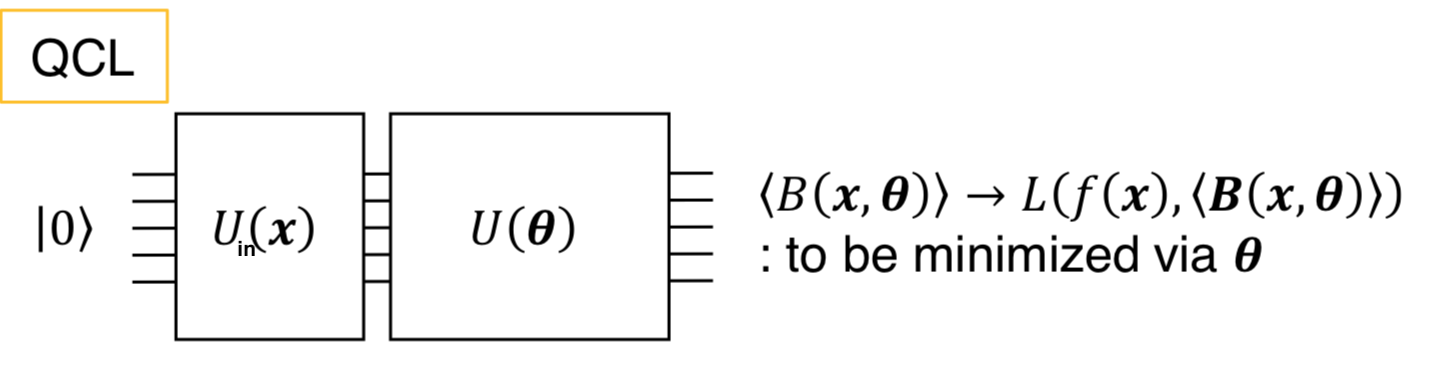

(In the QCL, input data $x$ is first converted to a quantum state using $U_{\text{in}}(x)$, and an output $y$ is obtained there from using a variational quantum circuit $U(\theta)$ and measurement (In the figure, the output is $\left<B(x,\theta)\right>$.) Source: Revised Figure 1 in reference [1].)

## Implementation using quantum simulator Qulacs 
In the following, a fitting of sin function $y=sin(\pi x)$ is performed as a demonstration of approximating function.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [3]:
########  Parameter  #############
nqubit = 3 ## number of qubit
c_depth = 3 ## depth of circuit
time_step = 0.77  ## elapsed time of time evolution with random Hamiltonian

## randomly take num_x_train points from [x_min, x_max] as teacher data.
x_min = - 1.; x_max = 1.;
num_x_train = 50

## one variable function to learn
func_to_learn = lambda x: np.sin(x*np.pi)

## seed of random number
random_seed = 0
## initialization of random number generator
np.random.seed(random_seed)

### Prepare training data

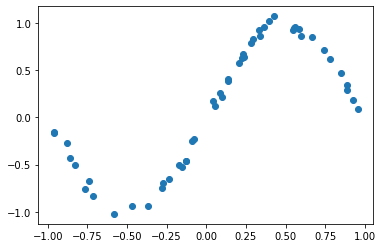

In [4]:
#### Prepare teacher data
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# Add noise to pure sine function assuming real data used
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

### Construct the input state
Firstly, create a gate $U_{\text{in}}(x_i)$ for embedding the input value $x_i$ in the initial state $\left|00...0\right>$.
According to reference [1], define $U_{\text{in}}(x_i)=\prod_jR^Z_j(\text{cos}^{-1}x^2)R^Y_j(\text{sin}^{-1}x)$ using rotation gates $R^Y_j(\theta)=e^{i\theta Y_j/2}, R^Z_j(\theta)=e^{i\theta Z_j/2}$.
The input $x_i$ is converted into quantum state $\left|\psi_\text{in}(x_i)\right>=U_{\text{in}}(x_i)\left|00...0\right>$.

In [5]:
## When using Google Colaboratory・please run in a local environment where Qulacs is not installed.
!pip install qulacs

In [6]:
# Create intial state
from qulacs import QuantumState, QuantumCircuit

state = QuantumState(nqubit) # Initial state |000>
state.set_zero_state()
print(state.get_vector())

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [7]:
# Function that creats a gate encoding x
def U_in(x):
    U = QuantumCircuit(nqubit)

    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)

    for i in range(nqubit):
        U.add_RY_gate(i, angle_y)
        U.add_RZ_gate(i, angle_z)

    return U

In [8]:
# Test initial state
x = 0.1 # appropriate value
U_in(x).update_quantum_state(state) # calculation of U_in|000>
print(state.get_vector())

[-6.93804351e-01+7.14937415e-01j -3.54871219e-02-3.51340074e-02j
 -3.54871219e-02-3.51340074e-02j  1.77881430e-03-1.76111422e-03j
 -3.54871219e-02-3.51340074e-02j  1.77881430e-03-1.76111422e-03j
  1.77881430e-03-1.76111422e-03j  8.73809020e-05+9.00424970e-05j]


### Construct variational quantum circuit $U(\theta)$
Next, a variational quantum circuit $U(\theta)$ to be optimized is created. The procedure is the following three steps:
1. Create a transverse magnetic field Ising Hamiltonian.
2. Create rotation gates.
3. Combine step1 and step2's gates alternatively to make a large variational quantum circuit $U(\theta)$.

#### 1.Create a transverse magnetic field Ising Hamiltonian
The expressiveness of the model is enhanced by increasing the complexity (entanglement) of the quantum circuit after performing time evolution based on the transverse magnetic field Ising model learned in section 4-2. (This part can be skipped unless you want to know the details.)

The Hamiltonian of transverse magnetic file Ising model is shown below, time evolution operator is defined as $U_{\text{rand}}=e^{-iHt}$:

\begin{equation}
H=\sum_{j=1}^N a_jX_j+\sum_{j=1}^N\sum_{k=1}^{j-1}J_{jk}Z_jZ_k
\end{equation}

Coefficient $a$ and $J$ is a uniform distribution of $[-1,1]$.

In [9]:
## Basic gate
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix()
Z_mat = Z(0).get_matrix()

In [10]:
## Function that creates fullsize gate.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Take list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...],
    Insert Identity into unrelated qubit
    make (2**nqubit, 2**nqubit) matrix:
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## Arrange 1-qubit gates and reduce with np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## an empty site is identity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)

In [11]:
#### Create time evolution operator by making random magnetic field and random coupling Ising Hamiltonian
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## random number in -1~1
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## Create a time evolution operator by diagonalization. H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT

In [12]:
time_evol_op.shape

(8, 8)

In [13]:
# Convert to qulacs gate
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

#### 2.Create rotation gates, 3.Create $U(\theta)$
Combine the time evolution operator $U_{\text{rand}}$ accroding to random transverse magnetic field Ising model and the operator of rotation gates operating on $j(=1,2,\dots n)$th qubit

\begin{equation}
U_\text{rot}(\theta_j^{(i)})=R_j^X(\theta_{j1}^{(i)})R_j^Z(\theta_{j2}^{(i)})R_j^X(\theta_{j3}^{(i)})
\end{equation}

to create variational quantum circuit $U(\theta)$:

\begin{equation}
U\Big(\{\theta_j^{(i)}\}_{i,j}\Big)= \prod_{i=1}^d\bigg(\bigg(\prod_{j=1}^nU_\text{rot}(\theta_j^{(i)})\bigg)\cdot U_\text{rand} \bigg)
\end{equation}

Here $i$ is a suffix representing the layer of the quantum circuit, and $U_\text{rand}$ and the above rotation are repeated in $d$ layers in total. There are $3\times n \times d$ parameters. The intial value of each $\theta$ is a uniform distribution of $[0,2\pi]$.

In [14]:
from qulacs import ParametricQuantumCircuit

In [15]:
# Assemble output gate U_out & set initial parameter values
U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)

In [16]:
# Get the list of initial values of the parameter theta
parameter_count = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]

In [17]:
theta_init

[6.007250646127814,
 4.046309757767312,
 2.663159813474645,
 3.810080933381979,
 0.12059442161498848,
 1.8948504571449056,
 4.14799267096281,
 1.8226113595664735,
 3.88310546309581,
 2.6940332019609157,
 0.851208649826403,
 1.8741631278382846,
 3.5811951525261123,
 3.7125630518871535,
 3.6085919651139333,
 4.104181793964002,
 4.097285684838374,
 2.71068197476515,
 5.633168398253273,
 2.309459341364396,
 2.738620094343915,
 5.6041197193647925,
 5.065466226710866,
 4.4226624059922806,
 0.6297441057449945,
 5.777279648887616,
 4.487710439107831]

For convenience, a function for updating parameter $\theta$ in $U(\theta)$ is created.

In [18]:
# Function that updates parameter theta
def set_U_out(theta):
    global U_out

    parameter_count = U_out.get_parameter_count()

    for i in range(parameter_count):
        U_out.set_parameter(i, theta[i])

### Measurement
In this demonstration, the output of the model is the expectation value of 0th qubit's Pauli Z on output state $\left|\psi_\text{out}\right>$, that is:

\begin{equation}
y(\theta,x_i)=\left<Z_0\right>=\left<\psi_\text{out}|Z_0|\psi_\text{out}\right>
\end{equation}

In [19]:
# Create observable Z_0
from qulacs import Observable
obs = Observable(nqubit)
obs.add_operator(2.,'Z 0') 
# Set observable as 2*Z。
# The reason for multiplying by 2 here is to expand the value range of the final <Z>.
# In order to cope with any unknown function, this constant also needs to be optimized as one parameter.

In [20]:
obs.get_expectation_value(state)

1.9899748742132415

### Combine a series of procedures into one function
The procedures up to this point can be combined to define a function that returns the predicted value $y(x_i,\theta)$ of the model from the input $x_i$.

In [21]:
# Function that gives prediction value y(x_i, theta) of the model from input x_i
def qcl_pred(x, U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()

    # Calculate input state
    U_in(x).update_quantum_state(state)

    # Calculate output state
    U_out.update_quantum_state(state)

    # Output of the model
    res = obs.get_expectation_value(state)

    return res

### Calculation of cost function
The cost function $L(\theta)$ is a mean square error (MSE) between the teacher data and the prediction data.

In [22]:
# Calculate cost function L
def cost_func(theta):
    '''
    theta: ndarray of length c_depth * nqubit * 3
    '''
    # update the parameter theta of U_out
    # global U_out
    set_U_out(theta)

    # calculate basing on data of num_x_train in total
    y_pred = [qcl_pred(x, U_out) for x in x_train]

    # quadratic loss
    L = ((y_pred - y_train)**2).mean()

    return L

In [23]:
# Value of cost function with initial parameter theta
cost_func(theta_init)

1.38892593161935

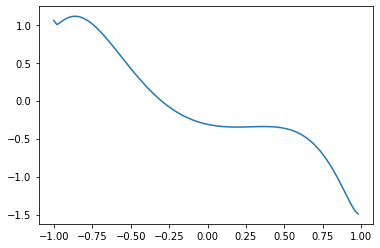

In [24]:
# Figure basing on inital parameter theta
xlist = np.arange(x_min, x_max, 0.02)
y_init = [qcl_pred(x, U_out) for x in xlist]
plt.plot(xlist, y_init)

### Learning (optimization by scipy.optimize.minimize)
Preparation is finally finished, and let's start learning from now on. Here, for simplicity, optimization is performed using the Nelder-Mead method, which does not need a gradient calculation formula. When using an optimization method that needs gradients (eg: the BFGS method), refer to the useful gradients calculation formulas introduced in Reference [1].

In [25]:
from scipy.optimize import minimize

In [26]:
%%time
# Learning (takes 14 seconds with the writer's PC)
result = minimize(cost_func, theta_init, method='Nelder-Mead')

CPU times: user 11.7 s, sys: 11.7 s, total: 23.4 s
Wall time: 14.2 s


In [27]:
# Value of cost_function after optimization
result.fun

0.003987076559624772

In [28]:
# Solution of theta by optimization
theta_opt = result.x
print(theta_opt)

[7.17242144 5.4043736  1.27744316 3.09192904 0.13144047 2.13757354
 4.58470259 2.01924008 2.96107066 2.91843537 1.0609229  1.70351774
 6.41114609 6.25686828 2.41619471 3.69387805 4.07551328 1.47666316
 3.4108701  2.28524042 1.75253621 7.44181397 3.20314179 5.11364648
 1.2831137  2.07306927 3.75112591]


### Plot results

In [29]:
# Insert optimized theta into U_out
set_U_out(theta_opt)

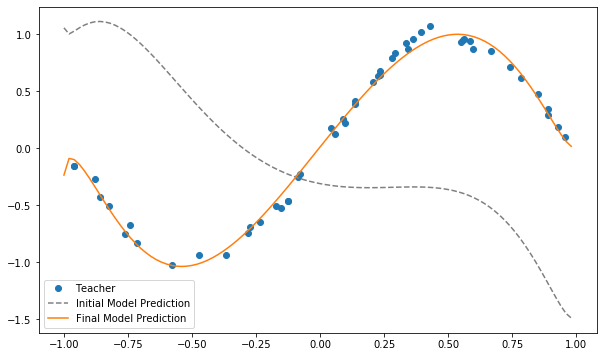

In [30]:
# Plot
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# teacher data
plt.plot(x_train, y_train, "o", label='Teacher')

# Figure basing on inital parameter theta
plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

# Prediction of the model
y_pred = np.array([qcl_pred(x, U_out) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()

It is clear that the approximation of the sin function was successful.

Here we dealt with a very simple task of a one-dimensional function approximation for both input and output, but it can be extended to approximation and classification problems with multidimensional inputs and outputs.

Motivated readers are encouraged to try to classify the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html), one of the typical machine learning datasets, in column `5.2c. Application of QCL to Machine Learning`.

## Reference
[1] K. Mitarai, M. Negoro, M. Kitagawa, and K. Fujii, “Quantum circuit learning”, [Phys. Rev. A 98, 032309 (2018)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.032309), arXiv：https://arxiv.org/abs/1803.00745

[2] V. Havlicek et al. , “Supervised learning with quantum-enhanced feature spaces”, [Nature 567, 209–212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), arXiv：https://arxiv.org/abs/1804.11326